In [1]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import imageio
import cv2
import os

import torch

In [3]:
# frames = []
# fps = 3
# # 
# for i in range(10):
#     path = f'data/synthetic/Segmentation/image_{i+1}.png'
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     frames.append(img)

# imageio.mimsave('results/test_movie_2.gif', frames, format='GIF', fps=fps)

In [4]:

# fps = 3

# positions_name = ['suprasternal', 'left_parasternal', 'apical', 'subcostal']


# for name in positions_name:
#     frames = []

#     for i in range(20):
#         path = f'data/synthetic/Segmentation/{name}/image_{i}.png'
#         img = cv2.imread(path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         frames.append(img)

#     imageio.mimsave(f'results/{name}_20.gif', frames, format='GIF', fps=fps)


In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2, os, json
import torch
from tqdm import tqdm
from PIL import Image

In [6]:
from src.scripts.models.U2Net import U2Net 
# from torch.utils.data import TensorDataset, DataLoader

device = 'cuda'
BATCH_SIZE = 2

In [7]:
real_path = 'data/real/20240708_095014_CARD'

ch4_names = [
    '20240708_101149959.avi',
    '20240708_101216285.avi',
    '20240708_101231366.avi',
    '20240708_101247312.avi',
    '20240708_101300234.avi',
    '20240708_101337896.avi',
    '20240708_101356037.avi',
    '20240708_101410225.avi',
    '20240708_101449930.avi',
    '20240708_101527783.avi', 
]
# ch2_names = []

ch4_paths = [ os.path.join(real_path, name) for name in ch4_names]
# ch2_paths = [ ]
ch4_paths[:5]

['data/real/20240708_095014_CARD/20240708_101149959.avi',
 'data/real/20240708_095014_CARD/20240708_101216285.avi',
 'data/real/20240708_095014_CARD/20240708_101231366.avi',
 'data/real/20240708_095014_CARD/20240708_101247312.avi',
 'data/real/20240708_095014_CARD/20240708_101300234.avi']

In [8]:
model_name = 'u2net-LV'   # calafun
model_saved_dir = 'results/U2Net'

model_path = F"{model_saved_dir}/{model_name}_best.pt"  # _best

model = U2Net().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [9]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred, out_shape=(128, 128)):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    # print(pred.shape)
    pred = pred.cpu().detach().numpy()
    pred = np.transpose(pred, (1, 2, 0))
    pred = sigmoid(pred)
    pred = pred / pred.max()
    pred = cv2.resize(pred, out_shape)
    pred = pred * 255
    pred = pred.astype('int')
    # pred = np.reshape(pred, (pred.shape[:2]))
    # pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)

    return pred

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
import skimage
import skimage.transform

In [11]:
fps = 4


for path in ch4_paths:
    frames = []
    cap = cv2.VideoCapture(path)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = frame[50:, 150:, :]
        image = cv2.resize(frame, (128, 128), cv2.INTER_LINEAR)
        # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        frame = prepare_input(frame)
        predict = model(frame)
        predict = prepare_output(predict, out_shape=(128, 128))
        # print(predict.shape, predict.max(), predict.min())  # (128, 128) 254 0

        # plt.imshow(predict)
        predict = skimage.color.gray2rgb(predict)
        # print(predict.shape, predict.max(), predict.min())  # (128, 128, 3) 254 0
        frame = np.concat([image, predict], axis=1)
        # plt.imshow(frame)

        frames.append(frame.astype('uint8'))

    cap.release()

    name = os.path.basename(path)
    name = name.split(".")[0]

    imageio.mimsave(f'results/U2Net/{name}.gif', frames, format='GIF', fps=fps)


[mjpeg @ 0x5a6e67818500] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5a6e6a532880] unable to decode APP fiel

In [12]:
len(frames), name, type(frames[0])

(121, '20240708_101527783', numpy.ndarray)

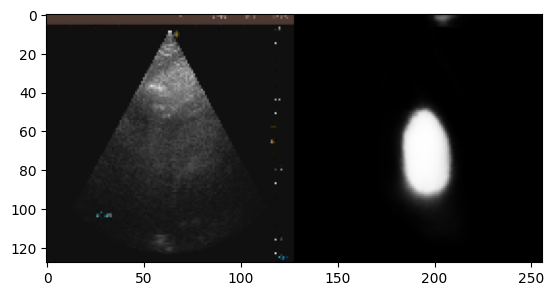

In [13]:
plt.imshow(frames[-1])